# REINFORCE

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gymnasium as gym

import matplotlib.pyplot as plt
from IPython import display

import tqdm

In [2]:
# 학습 파라미터
learning_rate = 0.0002
gamma         = 0.98

In [3]:
# Policy Based Network
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 2) # Left, Right 두개의 정책 추론
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1) # 확률분포로 변경
        return x

In [4]:
class MCAgent():
    def __init__(self):
        self.pi = Policy()  # policy network

    def prob_action(self, obs):
        return self.pi(obs)

    def update_pi(self, episode, optimizer):
        G = 0
        optimizer.zero_grad()
        for r, prob in episode[::-1]:
            G = r + gamma * G
            loss = -torch.log(prob) * G
            loss.backward()
        optimizer.step()

In [5]:
agent = MCAgent()  # Agent

In [6]:
# optimizer
optimizer = optim.Adam(agent.pi.parameters(), lr=learning_rate)

In [7]:
score = 0.0
max_score = 0.0
history = []

env = gym.make("CartPole-v1", render_mode="rgb_array")

p_bar = tqdm.trange(5000)
for i in p_bar:
    s, _ = env.reset()

    episode = []
    while True:
        prob = agent.prob_action(torch.from_numpy(s).float())  # 정책 추론
        a = Categorical(prob).sample().item()  # 확률 분포에 따른 액션 션택
        s_prime, r, done, oob, info = env.step(a)
        episode.append((r, prob[a]))
        s = s_prime
        
        score += r
        if done or oob:
            break

    agent.update_pi(episode, optimizer)

    if i % 10 == 9: # 10회 평균 저장
        p_bar.set_description(f'max: {max_score:.5f}, curr: {score:5f}')
        if score >= max_score: # 성능 개선이 있었으면
            torch.save(agent.pi.state_dict(), 'reinforce.pth')
            max_score = score
        history.append(score) # learning history
        score = 0.0

p_bar.close()
env.close()


ax: 4932.00000, curr: 4458.000000: 100%|██████████████████████████████████████████| 5000/5000 [07:04<00:00, 11.79it/s]

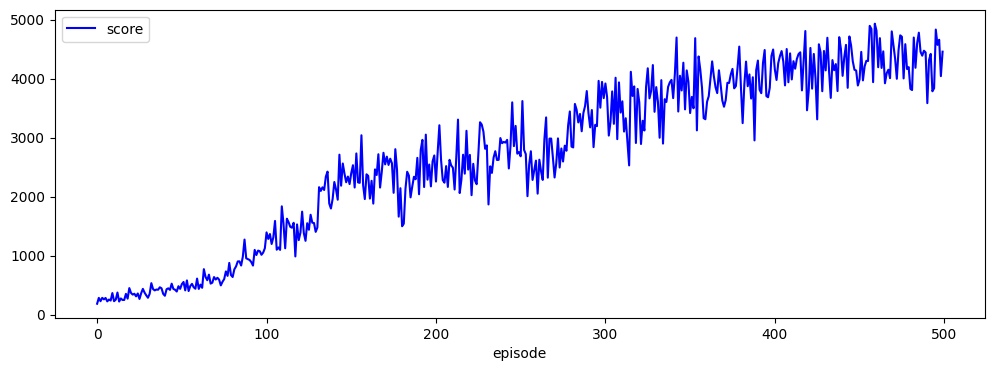

In [8]:
plt.figure(figsize=(12, 4))

plt.plot(history, 'b-', label='score')
plt.xlabel('episode')
plt.legend()
plt.show()

In [9]:
pi = Policy()
pi.load_state_dict(torch.load('reinforce.pth'))

<All keys matched successfully>

500.0


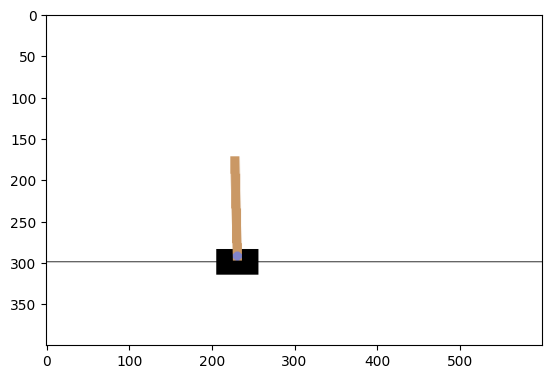

In [11]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
s, _ = env.reset()
img = plt.imshow(env.render())

score = 0.0
while True:
    # display
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    prob = pi(torch.from_numpy(s).float())  # 정책 추론
    a = Categorical(prob).sample().item()  # 확률 분포에 따른 액션 션택
    s_prime, r, done, oob, info = env.step(a)
    s = s_prime
    
    score += r
    if done or oob:
        break

env.close()
print(score)